In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Preparing my Data

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/stan_demontmarin/.fastai/data/imdb_sample/data_save.pkl'),
 PosixPath('/home/stan_demontmarin/.fastai/data/imdb_sample/texts.csv')]

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


We now need to create the TextDatabunch

In [5]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [6]:
TextDataBunch.from_csv??

The TextDataBunch transform the text into exploitable datas (numbers).

Behind the scene, it does a tokenization of every word, then a numericalization.

Since we did some calculations, let's save the result of these calculations so we don't have to do it again next time and save some time


In [7]:
data_lm.save()

Next time, the only thing we'll have to do is to load data_lm

In [8]:
data = load_data(path)

## Tokenization, what does it do ?

To see what the tokenizer has done behind the scenes, let's have a look at a few texts in a batch.

In [9]:
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative


- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

## Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [10]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [11]:
data.train_ds[0][0].data

array([   2,   13,  345, 3226, ...,  135,   15,  122,   11])

## With the data block API

In [12]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

In [13]:
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


# Let's do it for real with the full dataset

In [14]:
bs =48 
## Be carefull, nlp is gpu heavy so reduce the bs if needed

In [15]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/stan_demontmarin/.fastai/data/imdb/train'),
 PosixPath('/home/stan_demontmarin/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/stan_demontmarin/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/stan_demontmarin/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/stan_demontmarin/.fastai/data/imdb/test'),
 PosixPath('/home/stan_demontmarin/.fastai/data/imdb/README'),
 PosixPath('/home/stan_demontmarin/.fastai/data/imdb/unsup')]

In [16]:
(path/'train').ls()

[PosixPath('/home/stan_demontmarin/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/stan_demontmarin/.fastai/data/imdb/train/pos'),
 PosixPath('/home/stan_demontmarin/.fastai/data/imdb/train/neg'),
 PosixPath('/home/stan_demontmarin/.fastai/data/imdb/train/labeledBow.feat')]

In [17]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [18]:
data_lm.show_batch()


idx,text
0,"xxmaj othello was great ! \n \n xxmaj iago 's character was played so well by the xxmaj kenneth fellow ! even xxunk xxmaj iago is really evil and despicable , the character was played so well that it does what shakespeare intended for the charater to be , a pleasure for the audience to hate . i have to say that fishburne 's performance here was really good"
1,patrick xxmaj galloway an expert of the occult and a formidable fighter who is summoned by a friend to his estate in xxmaj ireland to investigate some weird xxunk . xxmaj the game is set in xxmaj ireland after xxmaj world xxmaj war one so do n't expect to find weapons like xxunk or rocket launchers . xxmaj all the weapons in the game can be considered antiques but the
2,"full of surprises . xxmaj confusing at times ... yes , but the twists and turns of the plot always keeps you in suspense . xxmaj the only thing that this movie had too much of was exploding cars . xxbos i saw this film earlier today , and i was amazed at how accurate the dialog is for the main characters . xxmaj it did n't feel like a"
3,"her ! xxmaj then i could enjoy the rest of the movie . \n \n xxmaj everywhere "" xxmaj harry xxmaj callahan "" ( xxmaj clint xxmaj eastwood ) goes , violence immediately follows xxrep 5 . within minutes ! xxmaj it happens so often it 's almost laughable but it makes for a fast - moving , entertaining film with a satisfying ending as all the scumbag villains"
4,"film 's abrupt bittersweet ending . xxmaj this is virtually a two - hander ( with all other characters - save for the nosy concierge of the apartment block in which the story takes place in its entirety - which include xxmaj loren 's gruff and fervently patriotic husband , surprisingly played by xxmaj john xxmaj vernon , appear only at the beginning and closing sequences ) ; still ,"


In [19]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [20]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


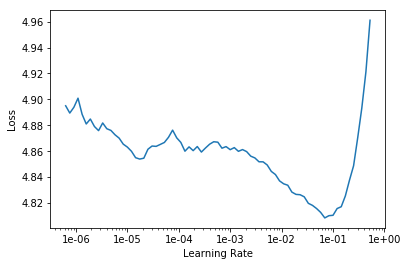

In [22]:
learn.recorder.plot(skip_end=15)

In [23]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.226264,4.055549,0.293441,23:54


In [25]:
learn.save('fit-head')

In [27]:
learn.load('fit-head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos shakespeare 's plays have a way of transcending time . xxmaj the language somehow breaks the time barrier . but perhaps it is the actors who really do that . 
 
  after the disappointment in xxmaj romeo and xxmaj juliet ( the version with xxmaj claire xxmaj danes and xxmaj leonardo dicaprio ) , was hesitant take on another modern rendition of xxmaj shakespeare . xxmaj to my surprise xxmaj othello was great ! 
 
  xxmaj iago 's character was played so well by the xxmaj kenneth fellow ! even xxunk xxmaj iago is really evil and despicable , the character was played so well that it does what shakespeare intended for the charater to be , a pleasure for the audience to hate . i have to say that fishburne 's performance here was really good as well . 
 
  i recommend this for shakespeare scholars and lazy students ( who refuse to read the book ) alike .,xxbos xxmaj noni xxmaj hazlehurst 's tour - de - fo

fastai.datasets.URLs

NameError: name 'fastai' is not defined